## Load libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.reload_library()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder

from wildboar.datasets import load_dataset

from tqdm.notebook import tqdm

# Growing spheres
from growingspheres.growingspheres import counterfactuals as counterfactuals_gs
from growingspheres.growingspheres import growingspheres
from growingspheres.growingspheres.utils import gs_utils

## Load dataset and split into train and test data

In [2]:
dataset = "ECG200"

x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

# remove rows with missing values
x = x_all[~np.isnan(x_all).any(axis=1)]
y_up = y_all[~np.isnan(x_all).any(axis=1)]

# change labels 0,1,...
le = LabelEncoder()
y = le.fit_transform(y_up)

classes = np.unique(y) # all class labels
total_examples, ts_length = x.shape

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=4, shuffle=True, stratify=None)

print('Dataset:', dataset)
print('Classes:', classes)
print('Dataset size:', total_examples)
print('Time series length:', ts_length)
for i in classes:
    print('Size class', i, ":", 100*np.sum(y==i)/total_examples,"%")

Dataset: ECG200
Classes: [0 1]
Dataset size: 200
Time series length: 96
Size class 0 : 33.5 %
Size class 1 : 66.5 %


## Figure 3(a)

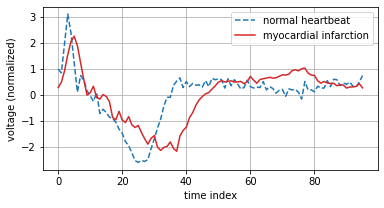

In [3]:
# Select one instance from each class
idxs_0 = np.where(y_test == 0)
idxs_1 = np.where(y_test == 1)

data_idx_0 = idxs_0[0][3] # class 0 
data_idx_1 = idxs_1[0][0] # class 1


# Plot
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(x_test[data_idx_0], "--", c="tab:blue", label="normal heartbeat")
ax.plot(x_test[data_idx_1], "-", c="tab:red", label="myocardial infarction")
ax.set_ylabel('voltage (normalized)')
ax.set_xlabel('time index')
#plt.xticks(np.arange(0,98,10))
ax.grid(1)
ax.legend(loc=0)
plt.savefig("figures/fig3a.pdf", dpi=100, bbox_inches="tight", format="pdf")

In [4]:
i = 4
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.30, random_state=i, shuffle=True, stratify=None)

# transform all time series to the frequency domain
max_len_coef = int(ts_length/2 + 1) # maximum number of coefficients

X_F_train = np.fft.rfft(x_train)
X_F_test = np.fft.rfft(x_test)


X_F_train_amp, train_norm_amp = normalize(np.absolute(X_F_train),return_norm=1)  # amplitude
X_F_train_ang = normalize(np.angle(X_F_train))     # phase
X_F_test_amp, test_norm_amp = normalize(np.absolute(X_F_test),return_norm=1)    # amplitude
X_F_test_ang, test_norm_ang = normalize(np.angle(X_F_test),return_norm=1)       # phase

# combine amp and phase into one array
X_F_train_amp_ang = np.empty((len(x_train),2*max_len_coef))
X_F_train_amp_ang[:,0::2] = X_F_train_amp
X_F_train_amp_ang[:,1::2] = X_F_train_ang
X_F_test_amp_ang = np.empty((len(x_test),2*max_len_coef))
X_F_test_amp_ang[:,0::2] = X_F_test_amp
X_F_test_amp_ang[:,1::2] = X_F_test_ang

# selected number of features
L = 12 # Select only first L <= max_len_coef coefficients

features_train = X_F_train_amp[:,:L]
features_test = X_F_test_amp[:,:L]

features = np.concatenate((features_test,features_train))
y_true_all = np.concatenate((y_train,y_test))
feature_labels = range(1,L+1)

# Classifier
model = ExtraTreesClassifier(random_state=1)
model.fit(features_train, y_train)

y_pred = model.predict(features_test)
y_pred_all = model.predict(features)
y_pred_proba = model.predict_proba(features_test)

accuracy = model.score(features_test, y_test)
print("Avg Accuracy:", accuracy)

Avg Accuracy: 0.9166666666666666


In [5]:
rands = 100

ce = []

for i in tqdm(range(rands)):

    data_idx = data_idx_1

    obs = X_F_test_amp[data_idx,:L].reshape(1,-1)

    CF = counterfactuals_gs.CounterfactualExplanation(obs, model.predict, target_class = None, method='GS', random_state = 123)
    CF.fit(n_in_layer=2000, first_radius=5, dicrease_radius=10, sparse=False, verbose=False)

    ce.append(CF.enemy)

  0%|          | 0/100 [00:00<?, ?it/s]

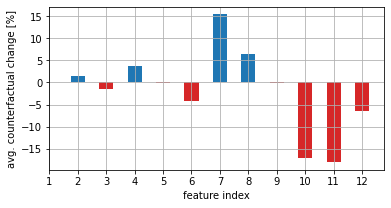

In [6]:
changes_all = np.array(ce/obs) - 1

changes = np.mean(changes_all, axis=0)

changes[0] = np.nan
changes_inc = changes.copy()
changes_dec = changes.copy()

changes_inc[changes <= 0] = np.nan
changes_dec[changes > 0] = np.nan

x_labels = range(1,L+1)

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.bar(x_labels, 100*(changes_inc), width=0.5, facecolor="tab:blue")
ax.bar(x_labels, 100*(changes_dec), width=0.5, facecolor="tab:red")
ax.set_ylabel('avg. counterfactual change [%]')
ax.set_xlabel('feature index')
plt.xticks(ticks = x_labels)
ax.grid(1)
#ax.set_ylim(-20,50)
#ax.legend(loc=2)
plt.savefig("figures/fig3b.pdf", dpi=100, bbox_inches="tight", format="pdf")